## 马尔科夫链建模

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_csv('online_retail_II.csv')  # 替换为实际文件路径

# 数据预处理
# 添加TotalPrice列
df['TotalPrice'] = df['Quantity'] * df['Price']

# 转换日期格式
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 移除取消订单（以'C'开头的发票）
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# 移除缺失CustomerID的记录
df = df.dropna(subset=['Customer ID'])

# 按发票分组，创建订单级数据集
orders = df.groupby(['Invoice', 'Customer ID', 'InvoiceDate']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

In [144]:
orders

,Invoice,Customer ID,InvoiceDate,Quantity,TotalPrice
0,489434,13085.0,2009-12-01 07:45:00,166,505.30
1,489435,13085.0,2009-12-01 07:46:00,60,145.80
2,489436,13078.0,2009-12-01 09:06:00,193,630.33
3,489437,15362.0,2009-12-01 09:08:00,145,310.75
4,489438,18102.0,2009-12-01 09:24:00,826,2286.24
...,...,...,...,...,...
37034,581583,13777.0,2011-12-09 12:23:00,76,124.60
37035,581584,13777.0,2011-12-09 12:25:00,120,140.64
37036,581585,15804.0,2011-12-09 12:31:00,278,329.05
37037,581586,13113.0,2011-12-09 12:49:00,66,339.20


In [145]:
# 计算消费金额的分位数
low_threshold = orders['TotalPrice'].quantile(0.33)
high_threshold = orders['TotalPrice'].quantile(0.67)
print(low_threshold)
print(high_threshold)

# 定义状态转换函数
def get_state(price):
    if price <= low_threshold:
        return 'L'  # 低消费状态
    elif price <= high_threshold:
        return 'M'  # 中等消费状态
    else:
        return 'H'  # 高消费状态

# 为每个订单添加状态标签
orders['State'] = orders['TotalPrice'].apply(get_state)

# 按客户分组并按时间排序
customer_sequences = orders.sort_values('InvoiceDate').groupby('Customer ID')['State'].apply(list)

# 初始化转移计数矩阵
states = ['L', 'M', 'H']
transition_counts = pd.DataFrame(0, index=states, columns=states)

# 遍历所有客户序列，统计状态转移
for seq in customer_sequences:
    for i in range(1, len(seq)):
        prev_state = seq[i-1]
        current_state = seq[i]
        transition_counts.loc[prev_state, current_state] += 1

# 计算转移概率矩阵
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)
print("状态转移矩阵:\n", transition_matrix)

202.2
400.61460000000005
状态转移矩阵:
           L         M         H
L  0.538931  0.285424  0.175645
M  0.285080  0.447038  0.267882
H  0.186924  0.265158  0.547918


In [146]:
# 计算平稳分布
# 使用特征向量法求解平稳分布
eig_vals, eig_vecs = np.linalg.eig(transition_matrix.T)
stationary = eig_vecs[:, np.argmin(np.abs(eig_vals - 1))]
stationary = stationary / stationary.sum()
print("平稳分布:", stationary)    

平稳分布: [0.33883171 0.3324996  0.32866868]


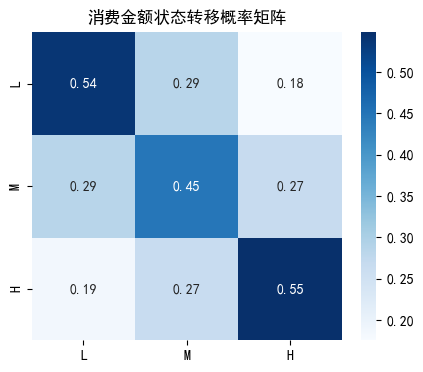

In [147]:
# 可视化状态转移矩阵
plt.figure(figsize=(5,4))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('消费金额状态转移概率矩阵')
# plt.savefig('fstate_transition_matrix.png')
plt.show()

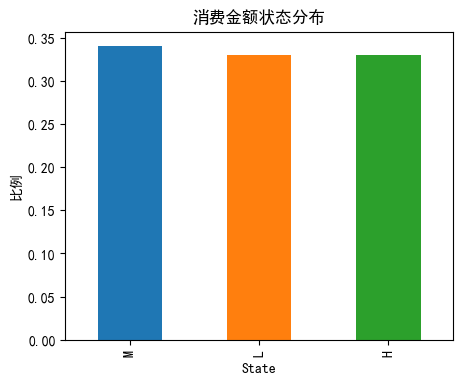

In [148]:
# 绘制状态分布图
state_counts = orders['State'].value_counts(normalize=True)
plt.figure(figsize=(5, 4))
state_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('消费金额状态分布')
plt.ylabel('比例')
# plt.savefig('figures/state_distribution.png')
plt.show()

In [149]:
def customer_example_analysis(orders):
    """
    示例客户分析：选择典型的高价值客户和中价值客户，分析其消费状态转移路径
    """
    # 1. 按客户分组，分析每个客户的消费行为特征
    customer_analysis = orders.groupby('Customer ID').agg(
        total_orders=('Invoice', 'nunique'),
        avg_spend=('TotalPrice', 'mean'),
        max_spend=('TotalPrice', 'max'),
        min_spend=('TotalPrice', 'min'),
        h_state_percentage=('State', lambda x: (x == 'H').mean()),
        m_state_percentage=('State', lambda x: (x == 'M').mean()),
        l_state_percentage=('State', lambda x: (x == 'L').mean()),
        state_sequence=('State', list)
    ).reset_index()
    
    # 2. 筛选有足够订单的客户（至少5单）
    customer_analysis = customer_analysis[customer_analysis['total_orders'] >= 5]
    
    # 3. 选择典型客户
    # 高价值客户：H状态比例高且平均消费高
    high_value_customers = customer_analysis.sort_values(
        by=['h_state_percentage', 'avg_spend'], 
        ascending=[False, False]
    ).head(10)
    
    # 中价值客户：M状态比例高且有一定波动
    medium_value_customers = customer_analysis[
        (customer_analysis['m_state_percentage'] > 0.5) &
        (customer_analysis['l_state_percentage'] > 0.1) &
        (customer_analysis['h_state_percentage'] < 0.3)
    ].sort_values(by='avg_spend', ascending=False).head(10)
    
    # 4. 从候选客户中选择两个具体示例
    # 高价值客户示例
    high_value_cust_id = high_value_customers.iloc[0]['Customer ID']
    # 中价值客户示例
    medium_value_cust_id = medium_value_customers.iloc[3]['Customer ID']
    
    # 5. 获取这两个客户的完整状态序列
    high_value_seq = customer_analysis[
        customer_analysis['Customer ID'] == high_value_cust_id
    ]['state_sequence'].iloc[0]
    
    medium_value_seq = customer_analysis[
        customer_analysis['Customer ID'] == medium_value_cust_id
    ]['state_sequence'].iloc[0]
    
    # 6. 绘制状态转移路径图
    plt.figure(figsize=(14, 10))
    
    # 高价值客户子图
    plt.subplot(2, 1, 1)
    plot_state_transition(high_value_seq, f'高价值客户 (ID: {high_value_cust_id})')
    
    # 中价值客户子图
    plt.subplot(2, 1, 2)
    plot_state_transition(medium_value_seq, f'中价值客户 (ID: {medium_value_cust_id})')
    
    plt.tight_layout()
    plt.savefig('figures/customer_markov.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 7. 计算个体转移矩阵和平稳分布
    print("\n高价值客户分析:")
    analyze_individual_customer(high_value_seq, high_value_cust_id)
    
    print("\n中价值客户分析:")
    analyze_individual_customer(medium_value_seq, medium_value_cust_id)
    
    return {
        'high_value_customer': high_value_cust_id,
        'medium_value_customer': medium_value_cust_id,
        'high_value_sequence': high_value_seq,
        'medium_value_sequence': medium_value_seq
    }

def plot_state_transition(state_sequence, title):
    """
    绘制单个客户的状态转移路径
    """
    # 状态到数值的映射
    state_map = {'L': 0, 'M': 1, 'H': 2}
    numeric_sequence = [state_map[s] for s in state_sequence]
    
    # 创建时间点（订单序列）
    time_points = list(range(len(state_sequence)))
    
    # 创建图形
    plt.plot(time_points, numeric_sequence, '-o', markersize=8, linewidth=2)
    
    # 添加状态标签
    for i, state in enumerate(state_sequence):
        plt.text(time_points[i], numeric_sequence[i] + 0.05, state, 
                ha='center', fontsize=12, fontweight='bold')
    
    # 设置Y轴刻度和标签
    plt.yticks([0, 1, 2], ['低消费 (L)', '中消费 (M)', '高消费 (H)'], fontsize=12)
    plt.xticks(time_points, [f"订单 {i+1}" for i in time_points], fontsize=10)
    
    # 设置网格和标题
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('订单序列', fontsize=12)
    plt.ylabel('消费状态', fontsize=12)
    
    # 设置Y轴范围
    plt.ylim(-0.2, 2.2)

def analyze_individual_customer(state_sequence, customer_id):
    """
    分析单个客户的状态转移特征
    """
    # 计算状态分布
    states = ['L', 'M', 'H']
    state_counts = {state: state_sequence.count(state) for state in states}
    total_orders = len(state_sequence)
    
    print(f"客户 {customer_id} 分析:")
    print(f"总订单数: {total_orders}")
    print(f"状态分布: L: {state_counts['L']} ({state_counts['L']/total_orders:.1%}), "
          f"M: {state_counts['M']} ({state_counts['M']/total_orders:.1%}), "
          f"H: {state_counts['H']} ({state_counts['H']/total_orders:.1%})")
    
    # 计算个体转移矩阵
    transition_counts = pd.DataFrame(0, index=states, columns=states)
    
    for i in range(1, len(state_sequence)):
        prev_state = state_sequence[i-1]
        current_state = state_sequence[i]
        transition_counts.loc[prev_state, current_state] += 1
    
    # 计算转移概率
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)
    
    print("\n转移概率矩阵:")
    print(transition_matrix)
    
    # 计算平稳分布（如果可能）
    if total_orders >= 3:
        try:
            # 使用特征向量法求解平稳分布
            eig_vals, eig_vecs = np.linalg.eig(transition_matrix.T)
            # 找到最接近1的特征值
            idx = np.argmin(np.abs(eig_vals - 1))
            stationary = eig_vecs[:, idx].real
            # 归一化
            stationary = stationary / stationary.sum()
            
            print("\n平稳分布估计:")
            for i, state in enumerate(states):
                print(f"{state}: {stationary[i]:.3f} ({stationary[i]:.1%})")
        except:
            print("\n无法计算平稳分布（矩阵特征值问题）")
    else:
        print("\n订单数不足，无法可靠计算平稳分布")

# 执行示例客户分析
print("开始示例客户分析...")
customer_examples = customer_example_analysis(orders)
print("示例客户分析完成!")

开始示例客户分析...

高价值客户分析:
客户 13902.0 分析:
总订单数: 5
状态分布: L: 0 (0.0%), M: 0 (0.0%), H: 5 (100.0%)

转移概率矩阵:
     L    M    H
L  0.0  0.0  0.0
M  0.0  0.0  0.0
H  0.0  0.0  1.0

平稳分布估计:
L: 0.000 (0.0%)
M: 0.000 (0.0%)
H: 1.000 (100.0%)

中价值客户分析:
客户 17679.0 分析:
总订单数: 7
状态分布: L: 1 (14.3%), M: 4 (57.1%), H: 2 (28.6%)

转移概率矩阵:
          L         M         H
L  0.000000  1.000000  0.000000
M  0.333333  0.333333  0.333333
H  0.000000  0.500000  0.500000

平稳分布估计:
L: 0.167 (16.7%)
M: 0.500 (50.0%)
H: 0.333 (33.3%)
示例客户分析完成!


## 5. 生存分析

In [150]:
# 步骤1：导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.cluster import KMeans

# 设置观测结束日期
end_date = pd.to_datetime('2011-12-09')

# 步骤2：计算RFM特征
print("计算RFM特征...")
customer_rfm = orders.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (end_date - x.max()).days),
    Frequency=('Invoice', 'nunique'),
    MonetaryValue=('TotalPrice', 'sum'),
    FirstPurchaseDate=('InvoiceDate', 'min'),
    LastPurchaseDate=('InvoiceDate', 'max')
).reset_index()

# 步骤3：计算购买间隔时间
customer_rfm['PurchaseDuration'] = (customer_rfm['LastPurchaseDate'] - customer_rfm['FirstPurchaseDate']).dt.days
customer_rfm['AvgPurchaseInterval'] = customer_rfm['PurchaseDuration'] / (customer_rfm['Frequency'] - 1)
customer_rfm['AvgPurchaseInterval'] = customer_rfm['AvgPurchaseInterval'].replace([np.inf, -np.inf], np.nan)

customer_rfm

计算RFM特征...


,Customer ID,Recency,Frequency,MonetaryValue,FirstPurchaseDate,LastPurchaseDate,PurchaseDuration,AvgPurchaseInterval
0,12346.0,324,12,77556.46,2009-12-14 08:34:00,2011-01-18 10:01:00,400,36.363636
1,12347.0,1,8,5633.32,2010-10-31 14:20:00,2011-12-07 15:52:00,402,57.428571
2,12348.0,74,5,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00,362,90.500000
3,12349.0,17,4,4428.69,2010-04-29 13:20:00,2011-11-21 09:51:00,570,190.000000
4,12350.0,309,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,0,NaN
...,...,...,...,...,...,...,...,...
5876,18283.0,2,22,2736.65,2010-02-19 17:16:00,2011-12-06 12:02:00,654,31.142857
5877,18284.0,430,1,461.68,2010-10-04 11:33:00,2010-10-04 11:33:00,0,NaN
5878,18285.0,659,1,427.00,2010-02-17 10:24:00,2010-02-17 10:24:00,0,NaN
5879,18286.0,475,2,1296.43,2009-12-16 10:45:00,2010-08-20 11:57:00,247,247.000000


In [151]:
# 步骤4：RFM经典分层
print("\n应用RFM经典分层方法...")
# 计算RFM均值
r_mean = customer_rfm['Recency'].mean()
f_mean = customer_rfm['Frequency'].mean()
m_mean = customer_rfm['MonetaryValue'].mean()

# 创建分类标志
customer_rfm['R_flag'] = customer_rfm['Recency'] <= r_mean  # 注意：Recency越小越好
customer_rfm['F_flag'] = customer_rfm['Frequency'] > f_mean
customer_rfm['M_flag'] = customer_rfm['MonetaryValue'] > m_mean

# 根据RFM标志进行分类
def rfm_classification(row):
    if row['R_flag'] and row['F_flag'] and row['M_flag']:
        return '重要价值客户'
    elif row['R_flag'] and row['F_flag'] and not row['M_flag']:
        return '消费潜力客户'
    elif row['R_flag'] and not row['F_flag'] and row['M_flag']:
        return '频次深耕客户'
    elif row['R_flag'] and not row['F_flag'] and not row['M_flag']:
        return '新客户'
    elif not row['R_flag'] and row['F_flag'] and row['M_flag']:
        return '重要价值流失预警客户'
    elif not row['R_flag'] and row['F_flag'] and not row['M_flag']:
        return '一般客户'
    elif not row['R_flag'] and not row['F_flag'] and row['M_flag']:
        return '高消费唤回客户'
    else:
        return '流失客户'
    
# 应用分类函数
customer_rfm['RFM_Class'] = customer_rfm.apply(rfm_classification, axis=1)

# 输出分类结果统计
class_counts = customer_rfm['RFM_Class'].value_counts()
class_perc = (class_counts / len(customer_rfm)) * 100
class_table = pd.DataFrame({
    '客户类别': class_counts.index,
    '客户数量': class_counts.values,
    '占比(%)': class_perc.round(2).values
}).sort_values('客户数量', ascending=False)

print("\nRFM分层结果统计:")
print(class_table)


应用RFM经典分层方法...

RFM分层结果统计:
         客户类别  客户数量  占比(%)
0        流失客户  2114  35.95
1         新客户  2089  35.52
2      重要价值客户   939  15.97
3      消费潜力客户   459   7.80
4      频次深耕客户   111   1.89
5        一般客户    68   1.16
6  重要价值流失预警客户    55   0.94
7     高消费唤回客户    46   0.78


C:\Users\Han Fu\AppData\Local\Temp\ipykernel_10364\1145980086.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='客户类别', y='占比(%)', data=class_table, palette='viridis')


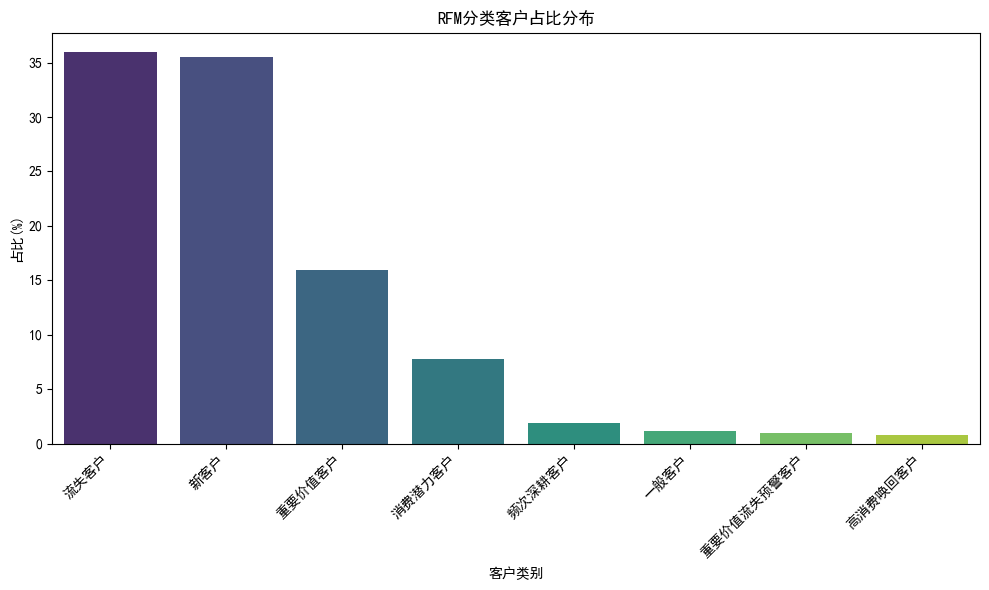

In [152]:
# 绘制客户占比柱状图
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='客户类别', y='占比(%)', data=class_table, palette='viridis')

ax.set_title('RFM分类客户占比分布')
ax.set_ylabel('占比(%)')
plt.xticks(rotation=45, ha='right')

# 保存图表为PNG文件
plt.tight_layout()
plt.savefig('./figures/rfm_percent.png', dpi=300)  # 保存图表
plt.show()

#### cox建模

In [153]:
# 步骤5：计算平均购买间隔统计
avg_interval_stats = customer_rfm['AvgPurchaseInterval'].describe(percentiles=[0.25, 0.5, 0.75])
print("\n顾客平均购买间隔时间统计:")
print(f"均值: {avg_interval_stats['mean']:.2f} 天")
print(f"中位数: {avg_interval_stats['50%']:.2f} 天")
print(f"标准差: {avg_interval_stats['std']:.2f} 天")


顾客平均购买间隔时间统计:
均值: 102.10 天
中位数: 72.22 天
标准差: 98.20 天


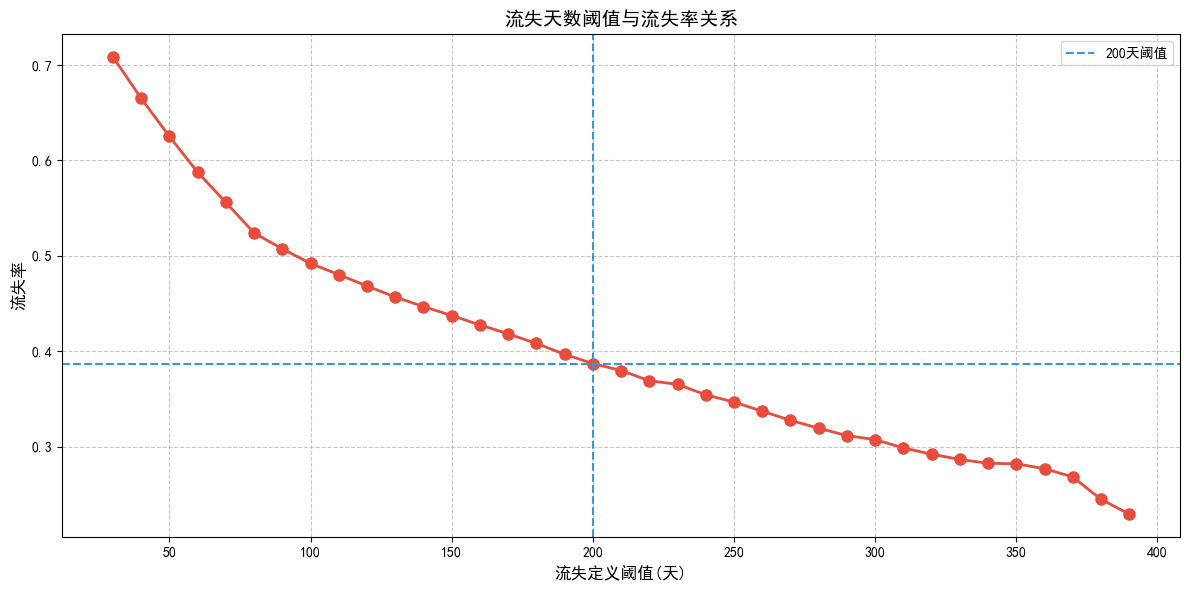


流失阈值分析图已保存至 figures/churn_threshold_analysis.png


In [154]:
# 步骤6：绘制流失阈值分析图
plt.figure(figsize=(12, 6))
thresholds = range(30, 400, 10)
churn_rates = [(customer_rfm['Recency'] > t).mean() for t in thresholds]

plt.plot(thresholds, churn_rates, 'o-', markersize=8, linewidth=2, color='#e74c3c')
plt.axvline(x=200, color='#3498db', linestyle='--', label='200天阈值')
plt.axhline(y=churn_rates[thresholds.index(200)], color='#3498db', linestyle='--')

plt.title('流失天数阈值与流失率关系', fontsize=14)
plt.xlabel('流失定义阈值(天)', fontsize=12)
plt.ylabel('流失率', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('figures/churn_threshold_analysis.png', dpi=300)
plt.show()
plt.close()
print("\n流失阈值分析图已保存至 figures/churn_threshold_analysis.png")

In [155]:
customer_rfm

,Customer ID,Recency,Frequency,MonetaryValue,FirstPurchaseDate,LastPurchaseDate,PurchaseDuration,AvgPurchaseInterval,R_flag,F_flag,M_flag,RFM_Class
0,12346.0,324,12,77556.46,2009-12-14 08:34:00,2011-01-18 10:01:00,400,36.363636,False,True,True,重要价值流失预警客户
1,12347.0,1,8,5633.32,2010-10-31 14:20:00,2011-12-07 15:52:00,402,57.428571,True,True,True,重要价值客户
2,12348.0,74,5,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00,362,90.500000,True,False,False,新客户
3,12349.0,17,4,4428.69,2010-04-29 13:20:00,2011-11-21 09:51:00,570,190.000000,True,False,True,频次深耕客户
4,12350.0,309,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,0,NaN,False,False,False,流失客户
...,...,...,...,...,...,...,...,...,...,...,...,...
5876,18283.0,2,22,2736.65,2010-02-19 17:16:00,2011-12-06 12:02:00,654,31.142857,True,True,False,消费潜力客户
5877,18284.0,430,1,461.68,2010-10-04 11:33:00,2010-10-04 11:33:00,0,NaN,False,False,False,流失客户
5878,18285.0,659,1,427.00,2010-02-17 10:24:00,2010-02-17 10:24:00,0,NaN,False,False,False,流失客户
5879,18286.0,475,2,1296.43,2009-12-16 10:45:00,2010-08-20 11:57:00,247,247.000000,False,False,False,流失客户


In [167]:
# 步骤7：定义流失事件和生存时间
customer_rfm['Churned'] = (customer_rfm['Recency'] >200).astype(int)
customer_rfm['SurvivalTime'] = customer_rfm['Recency'].apply(lambda x: min(x, 200))

# customer_rfm['SurvivalTime'] = customer_rfm['Recency']

# 步骤8：拟合Cox比例风险模型
cph = CoxPHFitter()
cox_df = customer_rfm[['SurvivalTime', 'Churned', 'Recency', 'Frequency', 'MonetaryValue']].copy()
cox_df=cox_df[cox_df['Recency']>=0]

cph.fit(cox_df, duration_col='SurvivalTime', event_col='Churned')

# 输出模型结果
print("\nCox模型结果:")
cph.summary


Cox模型结果:


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Recency,2.054689e-04,1.000205,0.000148,-0.000084,0.000495,0.999916,1.000495,0.0,1.391057,0.164208,2.606401
Frequency,8.637382e-04,1.000864,0.006029,-0.010954,0.012681,0.989106,1.012762,0.0,0.143252,0.886091,0.174473
MonetaryValue,5.030870e-07,1.000001,0.000008,-0.000015,0.000016,0.999985,1.000016,0.0,0.062298,0.950325,0.073507


#### Kaplan-Meier生存曲线

In [157]:
cox_df['SurvivalTime'].describe()

count    5846.000000
mean      110.166781
std        82.321817
min         0.000000
25%        25.000000
50%        96.000000
75%       200.000000
max       200.000000
Name: SurvivalTime, dtype: float64

In [158]:
print(cox_df['Churned'].value_counts())

Churned
0    3570
1    2276
Name: count, dtype: int64


In [159]:
cox_df

,SurvivalTime,Churned,Recency,Frequency,MonetaryValue
0,200,1,324,12,77556.46
1,1,0,1,8,5633.32
2,74,0,74,5,2019.40
3,17,0,17,4,4428.69
4,200,1,309,1,334.40
...,...,...,...,...,...
5876,2,0,2,22,2736.65
5877,200,1,430,1,461.68
5878,200,1,659,1,427.00
5879,200,1,475,2,1296.43


In [160]:
# 步骤10：绘制Kaplan-Meier生存曲线
recency_groups = cox_df['Recency'] # 转换回原始单位
freq_groups = cox_df['Frequency']  # 转换回原始单位
money_groups = cox_df['MonetaryValue'] # 转换回原始单位

print("Recency分组大小:")
print(((recency_groups <= 30).sum(), ((recency_groups > 30) & (recency_groups <= 90)).sum(), (recency_groups > 90).sum()))

print("Frequency分组大小:")
print(((freq_groups < 5).sum(), ((freq_groups >= 5) & (freq_groups < 10)).sum(), (freq_groups >= 10).sum()))

print("MonetaryValue分组大小:")
print(((money_groups < 100).sum(), ((money_groups >= 100) & (money_groups < 500)).sum(), (money_groups >= 500).sum()))

Recency分组大小:
(1680, 1183, 2983)
Frequency分组大小:
(3714, 1184, 948)
MonetaryValue分组大小:
(210, 1828, 3808)


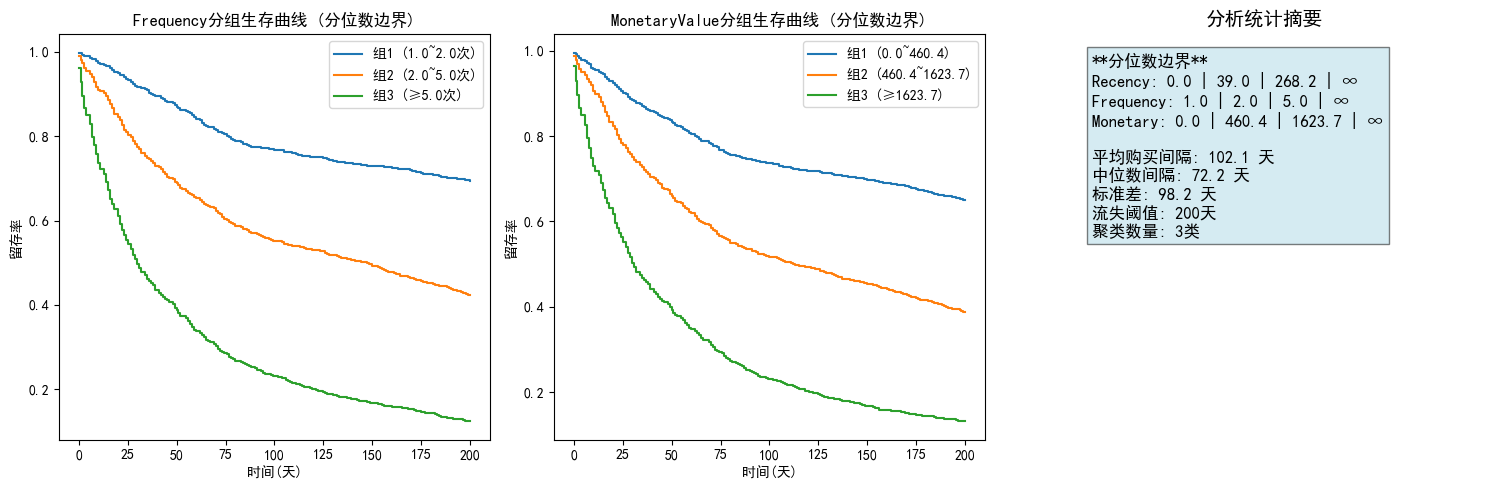

In [168]:
# 步骤3：基于分位数定义分组边界（确保每个组样本量均衡）
recency_bins = list(cox_df['Recency'].quantile([0, 0.33, 0.67, 1.0]))
freq_bins = list(cox_df['Frequency'].quantile([0, 0.33, 0.67, 1.0]))
money_bins = list(cox_df['MonetaryValue'].quantile([0, 0.33, 0.67, 1.0]))

# 将最后一个边界替换为无穷大，确保覆盖所有最大值
recency_bins[-1] = float('inf')
freq_bins[-1] = float('inf')
money_bins[-1] = float('inf')

# 步骤4：重新绘制生存曲线
plt.figure(figsize=(15, 5))
kmf = KaplanMeierFitter()

# 1. Recency分组生存曲线
# plt.subplot(3, 1, 1)
# kmf = KaplanMeierFitter()
# for i in range(len(recency_bins)-1):
#     if i == len(recency_bins)-2:  # 最后一组特殊处理
#         group = (cox_df['Recency'] >= recency_bins[i])
#     else:
#         group = (cox_df['Recency'] >= recency_bins[i]) & (cox_df['Recency'] < recency_bins[i+1])
    
#     if group.sum() > 0:
#         if i == len(recency_bins)-2:
#             label = f'组{i+1} (≥{recency_bins[i]:.1f}天)'
#         else:
#             label = f'组{i+1} ({recency_bins[i]:.1f}~{recency_bins[i+1]:.1f}天)'
        
#         kmf.fit(cox_df['SurvivalTime'][group], 
#                 1-cox_df['Churned'][group], 
#                 label=label)
#         kmf.plot(ci_show=False)

# plt.title('Recency分组生存曲线 (分位数边界)')
# plt.xlabel('时间(天)')
# plt.ylabel('留存率')
# plt.legend()

# 2. Frequency分组生存曲线
plt.subplot(1, 3, 1)
for i in range(len(freq_bins)-1):
    if i == len(freq_bins)-2:
        group = (cox_df['Frequency'] >= freq_bins[i])
    else:
        group = (cox_df['Frequency'] >= freq_bins[i]) & (cox_df['Frequency'] < freq_bins[i+1])
    
    if group.sum() > 0:
        if i == len(freq_bins)-2:
            label = f'组{i+1} (≥{freq_bins[i]:.1f}次)'
        else:
            label = f'组{i+1} ({freq_bins[i]:.1f}~{freq_bins[i+1]:.1f}次)'
        
        kmf.fit(cox_df['SurvivalTime'][group], 
                1-cox_df['Churned'][group], 
                label=label)
        kmf.plot(ci_show=False)

plt.title('Frequency分组生存曲线 (分位数边界)')
plt.xlabel('时间(天)')
plt.ylabel('留存率')
plt.legend()

# 3. MonetaryValue分组生存曲线
plt.subplot(1,3,2)
for i in range(len(money_bins)-1):
    if i == len(money_bins)-2:
        group = (cox_df['MonetaryValue'] >= money_bins[i])
    else:
        group = (cox_df['MonetaryValue'] >= money_bins[i]) & (cox_df['MonetaryValue'] < money_bins[i+1])
    
    if group.sum() > 0:
        if i == len(money_bins)-2:
            label = f'组{i+1} (≥{money_bins[i]:.1f})'
        else:
            label = f'组{i+1} ({money_bins[i]:.1f}~{money_bins[i+1]:.1f})'
        
        kmf.fit(cox_df['SurvivalTime'][group], 
                1-cox_df['Churned'][group], 
                label=label)
        kmf.plot(ci_show=False)

plt.title('MonetaryValue分组生存曲线 (分位数边界)')
plt.xlabel('时间(天)')
plt.ylabel('留存率')
plt.legend()

# 4. 统计信息 (添加分位数边界信息)
plt.subplot(1,3,3)
plt.axis('off')

# 计算分位数边界描述
recency_desc = " | ".join([f"{q:.1f}" for q in recency_bins[:-1]]) + " | ∞"
freq_desc = " | ".join([f"{q:.1f}" for q in freq_bins[:-1]]) + " | ∞"
money_desc = " | ".join([f"{q:.1f}" for q in money_bins[:-1]]) + " | ∞"

stats_text = f"""**分位数边界**
Recency: {recency_desc}
Frequency: {freq_desc}
Monetary: {money_desc}

平均购买间隔: {avg_interval_stats['mean']:.1f} 天
中位数间隔: {avg_interval_stats['50%']:.1f} 天
标准差: {avg_interval_stats['std']:.1f} 天
流失阈值: 200天
聚类数量: 3类"""

plt.text(0.1, 0.5, stats_text, fontsize=12, 
         bbox=dict(facecolor='lightblue', alpha=0.5))
plt.title('分析统计摘要', fontsize=14)

plt.tight_layout()
plt.savefig("figures/km_curves.png")
plt.show()
